In [4]:
# ✅ Fix Plan: Re-merge the anomaly results with full original data

# 🔁 Step 1: Reload the original cleaned dataset (before scaling)
import pandas as pd

# Load the original full dataset (with all numeric + time fields)
df_full = pd.read_csv(r"C:\Users\Otala\Desktop\cleaned_numeric_combined.csv")


In [5]:
# 🔁 Step 2: Reload anomaly labels from your scaled model
# Reload the previously predicted anomalies
anomaly_labels = pd.read_csv(r"C:\Users\Otala\Desktop\anomalies_only.csv")

# Check shape
print(f"Anomalies shape: {anomaly_labels.shape}")


Anomalies shape: (56264, 79)


In [6]:
# 🔁 Step 3: Re-run the model to regenerate anomaly column on full data

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import numpy as np

# Step 1: Clean again
df_full = df_full.replace([np.inf, -np.inf], np.nan)
df_full = df_full.dropna()

# Step 2: Scale
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_full.values)

# Step 3: Predict
model = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
predictions = model.fit_predict(scaled_features)

# Step 4: Attach labels to full data
df_full['anomaly'] = predictions
df_full['anomaly'] = df_full['anomaly'].map({1: 'Normal', -1: 'Anomaly'})

# Step 5: Filter anomalies with full columns
anomalies = df_full[df_full['anomaly'] == 'Anomaly']
print(f"✅ Refreshed anomalies with Flow Duration: {anomalies.shape}")


✅ Refreshed anomalies with Flow Duration: (56264, 79)


In [7]:
# 🔁 Step 4: Save Updated Anomaly Dataset with Flow Duration

anomalies.to_csv(r"C:\Users\Otala\Desktop\anomalies_with_duration.csv", index=False)


In [11]:
# 📘 Cell 1: Imports + Load Anomalies
import pandas as pd
import matplotlib.pyplot as plt

# Load the anomalies data (updated version with Flow Duration)
file_path = r"C:\Users\Otala\Desktop\anomalies_with_duration.csv"
df = pd.read_csv(file_path)

# ✅ Clean all column names (removes leading/trailing whitespace)
df.columns = df.columns.str.strip()

print(f"✅ Loaded anomalies with shape: {df.shape}")
df.head()


✅ Loaded anomalies with shape: (56264, 79)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,anomaly
0,443,101027175,14,12,1029,991,460,0,73.500000,150.040379,...,32,1048172.0,1296391.188,1964859,131485,49400000.0,12900000.0,58500000,40300000,Anomaly
1,389,115791754,22,13,2986,6356,1305,0,135.727273,379.293351,...,32,20311.0,0.000,20311,20311,116000000.0,0.0,116000000,116000000,Anomaly
2,3268,115812212,22,13,2986,6356,1305,0,135.727273,379.293351,...,32,19638.0,0.000,19638,19638,116000000.0,0.0,116000000,116000000,Anomaly
3,53,98492066,3,3,147,393,56,40,49.000000,8.185353,...,20,1101027.0,0.000,1101027,1101027,97300000.0,0.0,97300000,97300000,Anomaly
4,53,93196139,2,2,104,219,56,48,52.000000,5.656854,...,20,71252.0,0.000,71252,71252,93100000.0,0.0,93100000,93100000,Anomaly


In [12]:
# 📘 Cell 2: Estimate λ (Arrival Rate)
# Convert Flow Duration to seconds (if it exists and is in nanoseconds)
if 'Flow Duration' in df.columns:
    df['Flow Duration (s)'] = df['Flow Duration'] / 1e9
    total_time = df['Flow Duration (s)'].sum()
    arrival_rate = len(df) / total_time  # λ = total arrivals / total time
    print(f"📥 Estimated arrival rate λ ≈ {arrival_rate:.4f} requests/sec")
else:
    print("❌ 'Flow Duration' not found. Using fallback: 1 row = 1 second.")
    arrival_rate = len(df) / len(df)  # fallback = 1/sec

print(df.columns.tolist())



📥 Estimated arrival rate λ ≈ 10.9545 requests/sec
['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', '

In [13]:
# 📘 Cell 3: Estimate W (Average Time in System)

# 📘 Cell 3: Estimate average time in system (W)
avg_time = df['Flow Duration (s)'].mean()
print(f"⏱️ Average time in system W ≈ {avg_time:.4f} seconds")


⏱️ Average time in system W ≈ 0.0913 seconds


In [14]:
# 📘 Cell 4: Apply Little’s Theorem (L = λ * W)

L = arrival_rate * avg_time
print(f"📦 Little's Theorem Result: L ≈ {L:.4f} concurrent anomaly flows (on average)")


📦 Little's Theorem Result: L ≈ 1.0000 concurrent anomaly flows (on average)


C:\Users\Otala\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9203 (\N{HOURGLASS WITH FLOWING SAND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


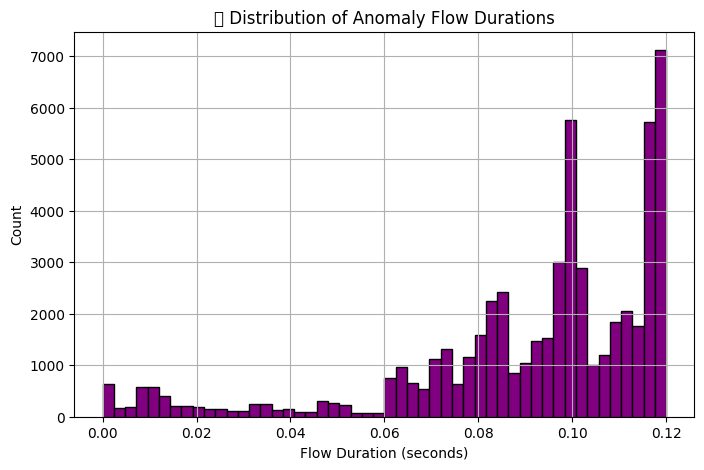

In [15]:
# 📘 Cell 5: Visualize Flow Durations

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(df['Flow Duration (s)'], bins=50, color='purple', edgecolor='black')
plt.title("⏳ Distribution of Anomaly Flow Durations")
plt.xlabel("Flow Duration (seconds)")
plt.ylabel("Count")
plt.grid(True)
plt.show()
